    TRANFER LEARNING BY FREEZING ALL LAYERS EXCEPT THE NEW FINAL LAYER, THE FROZEN LAYER ARE USED AS FEATURE EXTRACTOR

# Import Libraries

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
%matplotlib

Using matplotlib backend: TkAgg


In [2]:
path = '/home/n/Videos/datasets/hymenoptera_data/'

# Define data Transformation

In [3]:
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define the data pipleline

In [4]:
image_set = torchvision.datasets.ImageFolder(f'{path}train',data_transform)
data_loaders = torch.utils.data.DataLoader(image_set,shuffle=True,num_workers=0,batch_size=10)

In [5]:
class_names = image_set.classes
dataset_sizes = len(image_set)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [6]:
len(image_set)

244

# Generic Fucntion for image displaying dirctly taken from pytorch example

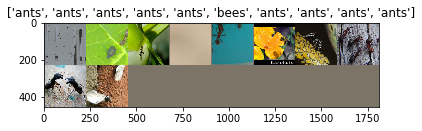

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(data_loaders))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



# Define the model for usage

In [8]:
model_ft = torchvision.models.vgg16(pretrained=True)
# freezing all gradients
for param in model_ft.parameters():
    param.requires_grad = False
model_ft.classifier = nn.Sequential(
                nn.Dropout(),
                nn.Linear(25088, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Linear(4096, 2),
)

model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only new layer parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [9]:
def train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,n_epochs=25):
    import time, copy
    since = time.time()

    best_w = copy.deepcopy(model_ft.state_dict())
    best_acc = 0.0
    
    for e in range(n_epochs):
        exp_lr_scheduler.step()
        model_ft.train()
        
        running_loss = 0.0
        running_corrects = 0

        
        for data in data_loaders:
            inputs,labels = data
            inputs = torch.autograd.variable(inputs.cuda())
            labels = torch.autograd.variable(labels.cuda())
            
            optimizer_ft.zero_grad()
            
            outputs = model_ft(inputs)
            loss = criterion(outputs,labels)
            _,preds = torch.max(outputs,1)
            
            # compute loss grad and propagate
            loss.backward()
            optimizer_ft.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                e, epoch_loss, epoch_acc))

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_w = copy.deepcopy(model_ft.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Train Acc: {:4f}'.format(best_acc))

    # load best model weights
    model_ft.load_state_dict(best_w)
    return model_ft
            
            
            

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
model_ft = train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,n_epochs=25)

/home/n/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/autograd/__init__.py:166: UserWarning: torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead
  warnings.warn("torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead")


0 Loss: 0.0337 Acc: 0.0205
0 Loss: 0.0623 Acc: 0.0451
0 Loss: 0.0940 Acc: 0.0533
0 Loss: 0.1183 Acc: 0.0861
0 Loss: 0.1460 Acc: 0.1148
0 Loss: 0.1756 Acc: 0.1311
0 Loss: 0.2042 Acc: 0.1516
0 Loss: 0.2325 Acc: 0.1721
0 Loss: 0.2578 Acc: 0.2008
0 Loss: 0.2821 Acc: 0.2254
0 Loss: 0.3091 Acc: 0.2418
0 Loss: 0.3446 Acc: 0.2541
0 Loss: 0.3731 Acc: 0.2664
0 Loss: 0.3960 Acc: 0.2992
0 Loss: 0.4216 Acc: 0.3279
0 Loss: 0.4463 Acc: 0.3484
0 Loss: 0.4732 Acc: 0.3730
0 Loss: 0.4934 Acc: 0.4016
0 Loss: 0.5205 Acc: 0.4262
0 Loss: 0.5430 Acc: 0.4508
0 Loss: 0.5583 Acc: 0.4877
0 Loss: 0.5790 Acc: 0.5164
0 Loss: 0.5894 Acc: 0.5574
0 Loss: 0.6121 Acc: 0.5820
0 Loss: 0.6213 Acc: 0.5943

1 Loss: 0.0276 Acc: 0.0205
1 Loss: 0.0359 Acc: 0.0574
1 Loss: 0.0525 Acc: 0.0943
1 Loss: 0.0645 Acc: 0.1311
1 Loss: 0.0794 Acc: 0.1680
1 Loss: 0.1024 Acc: 0.1926
1 Loss: 0.1150 Acc: 0.2295
1 Loss: 0.1281 Acc: 0.2664
1 Loss: 0.1393 Acc: 0.3033
1 Loss: 0.1507 Acc: 0.3402
1 Loss: 0.1711 Acc: 0.3689
1 Loss: 0.1848 Acc: 0.4057


12 Loss: 0.0043 Acc: 0.1230
12 Loss: 0.0077 Acc: 0.1639
12 Loss: 0.0180 Acc: 0.2008
12 Loss: 0.0236 Acc: 0.2377
12 Loss: 0.0277 Acc: 0.2787
12 Loss: 0.0307 Acc: 0.3197
12 Loss: 0.0410 Acc: 0.3566
12 Loss: 0.0528 Acc: 0.3893
12 Loss: 0.0577 Acc: 0.4303
12 Loss: 0.0594 Acc: 0.4713
12 Loss: 0.0633 Acc: 0.5082
12 Loss: 0.0636 Acc: 0.5492
12 Loss: 0.0675 Acc: 0.5902
12 Loss: 0.0736 Acc: 0.6270
12 Loss: 0.0759 Acc: 0.6680
12 Loss: 0.0849 Acc: 0.7049
12 Loss: 0.0856 Acc: 0.7459
12 Loss: 0.0962 Acc: 0.7828
12 Loss: 0.0971 Acc: 0.8238
12 Loss: 0.1066 Acc: 0.8607
12 Loss: 0.1103 Acc: 0.8975
12 Loss: 0.1271 Acc: 0.9344
12 Loss: 0.1307 Acc: 0.9508

13 Loss: 0.0088 Acc: 0.0328
13 Loss: 0.0109 Acc: 0.0738
13 Loss: 0.0125 Acc: 0.1148
13 Loss: 0.0201 Acc: 0.1557
13 Loss: 0.0305 Acc: 0.1885
13 Loss: 0.0454 Acc: 0.2254
13 Loss: 0.0549 Acc: 0.2582
13 Loss: 0.0556 Acc: 0.2992
13 Loss: 0.0593 Acc: 0.3402
13 Loss: 0.0655 Acc: 0.3770
13 Loss: 0.0685 Acc: 0.4139
13 Loss: 0.0727 Acc: 0.4549
13 Loss: 0.0777 Acc

23 Loss: 0.0941 Acc: 0.8197
23 Loss: 0.1006 Acc: 0.8566
23 Loss: 0.1078 Acc: 0.8893
23 Loss: 0.1096 Acc: 0.9303
23 Loss: 0.1156 Acc: 0.9426

24 Loss: 0.0010 Acc: 0.0410
24 Loss: 0.0050 Acc: 0.0820
24 Loss: 0.0094 Acc: 0.1230
24 Loss: 0.0205 Acc: 0.1598
24 Loss: 0.0212 Acc: 0.2008
24 Loss: 0.0386 Acc: 0.2295
24 Loss: 0.0438 Acc: 0.2664
24 Loss: 0.0582 Acc: 0.3033
24 Loss: 0.0611 Acc: 0.3443
24 Loss: 0.0627 Acc: 0.3852
24 Loss: 0.0656 Acc: 0.4262
24 Loss: 0.0662 Acc: 0.4672
24 Loss: 0.0732 Acc: 0.5041
24 Loss: 0.0761 Acc: 0.5451
24 Loss: 0.0892 Acc: 0.5738
24 Loss: 0.0915 Acc: 0.6148
24 Loss: 0.0939 Acc: 0.6557
24 Loss: 0.0966 Acc: 0.6967
24 Loss: 0.0979 Acc: 0.7377
24 Loss: 0.1066 Acc: 0.7746
24 Loss: 0.1135 Acc: 0.8156
24 Loss: 0.1147 Acc: 0.8566
24 Loss: 0.1172 Acc: 0.8975
24 Loss: 0.1227 Acc: 0.9385
24 Loss: 0.1378 Acc: 0.9508

Training complete in 3m 14s
Best Train Acc: 0.971311


# Use below codes to verify the result

In [ ]:
from PIL import Image
import os
from torchvision import transforms
imsize = 256
loader = transforms.Compose([transforms.Resize(imsize),transforms.RandomCrop(224), transforms.ToTensor(),transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])])


def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).cuda()
    image = torch.autograd.Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU
# for x in range(0,50):
#     image = image_loader(f'{data_dir}/train/ants/{files[x]}')
# #     h = vgg16.features(image)
# #     h = h.reshape((1,49*512))
# #     k = vgg16.classifier[:3](h)
# #     k = vgg16(image)
#     n = model_ft(image)
# #     n = n.reshape((1,2))
#     _, preds = torch.max(n.data, 1)
#     print(x,preds) #assumes that you're using GPU


# For one type

In [ ]:
files = os.listdir(f'{data_dir}/train/ants')[:556]

for x in range(0,50):
    image = image_loader(f'{data_dir}/train/ants/{files[x]}')
#     h = vgg16.features(image)
#     h = h.reshape((1,49*512))
#     k = vgg16.classifier[:3](h)
#     k = vgg16(image)
    n = model_ft(image)
#     n = n.reshape((1,2))
    _, preds = torch.max(n.data, 1)
    print(x,preds)

# For another type

In [ ]:
files = os.listdir(f'{data_dir}/train/bees')[:556]

for x in range(0,50):
    image = image_loader(f'{data_dir}/train/bees/{files[x]}')
#     h = vgg16.features(image)
#     h = h.reshape((1,49*512))
#     k = vgg16.classifier[:3](h)
#     k = vgg16(image)
    n = model_ft(image)
#     n = n.reshape((1,2))
    _, preds = torch.max(n.data, 1)
    print(x,preds)